In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.facecolor'] = 'white'

In [74]:
# open compressor_data.xlsx

water_50_outlet_data = pd.read_excel('compressor_data.xlsx', sheet_name='water_50_outlet')
water_25_outlet_data = pd.read_excel('compressor_data.xlsx', sheet_name='water_25_outlet')
water_50_inlet_data = pd.read_excel('compressor_data.xlsx', sheet_name='water_50_inlet')
water_25_inlet_data = pd.read_excel('compressor_data.xlsx', sheet_name='water_25_inlet')
glycerol_data = pd.read_excel('compressor_data.xlsx', sheet_name='glycerol')

do =	79.3* 1e-3 # mm
ro = do / 2
di =	25.2 * 1e-3 # mm
ri = di / 2 

mmHg = 754
rhoHg = 13600
g = 9.80665
P0 = mmHg * rhoHg * g / 1e3
a = 0.193

dyn_visc_water = 1.054 * 1e-6

rho_water = 998.6
rho_glycerol = 1170

Time_water = 40.35
Time_glycerol = 102.01

dyn_visc_glycerol = dyn_visc_water * (Time_glycerol * rho_glycerol / 2) / (Time_water * rho_water / 10)

print(P0)
print(dyn_visc_water)
print(dyn_visc_glycerol)



100561.31176
1.054e-06
1.5610043875552166e-05


In [75]:

def flow_coeff(Qdot, N):
    return Qdot / (N * do ** 3)

def pressure_coeff( dp, N, rho):
    return dp / (rho * N ** 2 * do ** 2)

def Nf(f):
    return f * 2855 / 50 * 2 * np.pi / 60

print(Nf(50))
print(Nf(25))

298.9749008666286
149.4874504333143


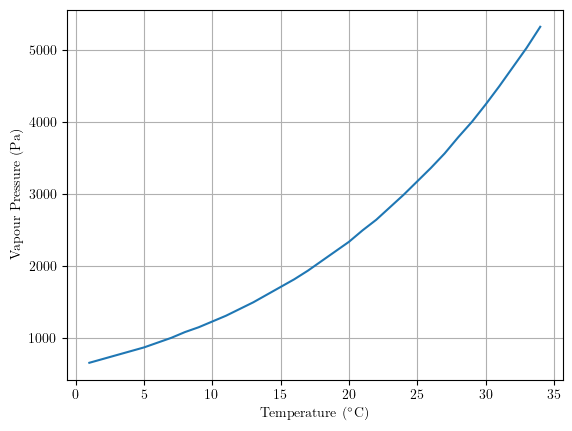

In [76]:
import scipy.interpolate as interp

# https://www.wiredchemist.com/chemistry/data/vapor-pressure
vapour_temps = np.arange(1, 35, 1)
vapour_pressures = np.array(
[
4.9,
5.3,
5.7,
6.1,
6.5,
7.0,
7.5,
8.1,
8.6,
9.2,
9.8,
10.5,
11.2,
12.0,
12.8,
13.6,
14.5,
15.5,
16.5,
17.5,
18.7,
19.8,
21.1,
22.4,
23.8,
25.2,
26.7,
28.4,
30.0,
31.8,
33.7,
35.7,
37.7,
39.9,
]
)

def interp_vapour_pressure(T):
    vapour_pressures_pa = vapour_pressures 
    f = interp.interp1d(vapour_temps, vapour_pressures_pa)
    return f(T) * 133.322 # convert torr to Pa

def plot_water_non_dims(data, freq, label = ""):
    Qdot = data["Mass Flow"] / rho_water
    N = Nf(freq)
    nonD_Q = flow_coeff(Qdot, N)
    nonD_P = pressure_coeff(data["P_rise Compresor"] * 1e3, N, rho_water)

    plt.plot(nonD_Q, nonD_P, label = label, linewidth=0.5)

def plot_suction_vs_flow_inlet(data, freq, label = ""): # INVALID FOR OUTLET_DATA

    Qdot = data["Mass Flow"] / rho_water
    N = Nf(freq)
    nonD_Q = flow_coeff(Qdot, N)

    Poutlet = P0 + 0.570 * rho_water * g
    Pinlet = Poutlet - data["P_rise Compresor"] * 1e3

    dP = Pinlet - interp_vapour_pressure(data["Temperature"])

    nonD_Psuction = pressure_coeff(dP, N, rho_water)
    plt.plot(nonD_Q, nonD_Psuction, label = label)


plt.plot(vapour_temps, vapour_pressures * 133.322)
plt.xlabel("Temperature ($^\circ$C)")
plt.ylabel("Vapour Pressure (Pa)")
plt.grid()

plt.savefig("vapour_pressure_water.png", dpi = 300)
plt.show()


Text(0, 0.5, 'Cavitation Number $C_t$')

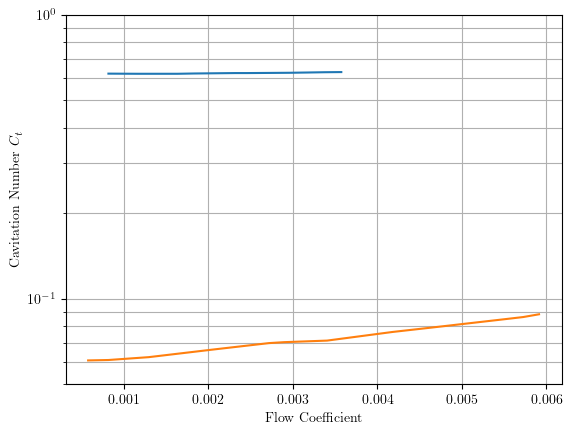

In [77]:
plot_suction_vs_flow_inlet(water_25_inlet_data, 25, )
plot_suction_vs_flow_inlet(water_50_inlet_data, 50)
plt.yscale('log')
plt.ylim(.5e-1, 1e0)
plt.grid( which='both', axis='both')
plt.xlabel("Flow Coefficient")
plt.ylabel("Cavitation Number $C_t$")

# Glycerine circuit

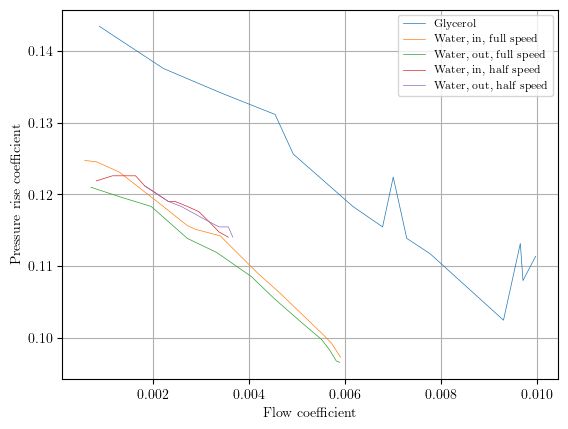

In [78]:

def plot_glycerol_non_dims(data, freq, label = ""):
    Qdot = data["flow rate kg/s"] / rho_water
    N = Nf(freq)
    nonD_Q = flow_coeff(Qdot, N)
    nonD_P = pressure_coeff(data["pressure"] * 1e3, N, rho_water)

    # sort the data
    data = np.array([nonD_Q, nonD_P])
    data = data[:, np.argsort(data[0])]
    nonD_Q = data[0]
    nonD_P = data[1]

    if False:
        outliers = [-1, -2, -3, -7]

        nonD_P_corrected = np.delete(nonD_P, outliers)
        nonD_Q_corrected = np.delete(nonD_Q, outliers)

        nonD_P_outliers = nonD_P[outliers]
        nonD_Q_outliers = nonD_Q[outliers]

        plt.plot(nonD_Q_corrected, nonD_P_corrected, label = label, linewidth=0.5)
        plt.scatter(nonD_Q_outliers, nonD_P_outliers, s=10, marker = 'x')
    else:

        plt.plot(nonD_Q, nonD_P, label = label, linewidth=0.5)

plot_glycerol_non_dims(glycerol_data, 50, f"Glycerol")
plot_water_non_dims(water_50_inlet_data, 50, f"Water, in, full speed")
plot_water_non_dims(water_50_outlet_data, 50, f"Water, out, full speed")
plot_water_non_dims(water_25_inlet_data, 25, f"Water, in, half speed")
plot_water_non_dims(water_25_outlet_data, 25, f"Water, out, half speed")

plt.xlabel('Flow coefficient')
plt.ylabel('Pressure rise coefficient')
plt.legend(prop={'size': 8})
plt.grid()

plt.savefig('compressor_non_dims.png', dpi=600, bbox_inches='tight')
plt.show()


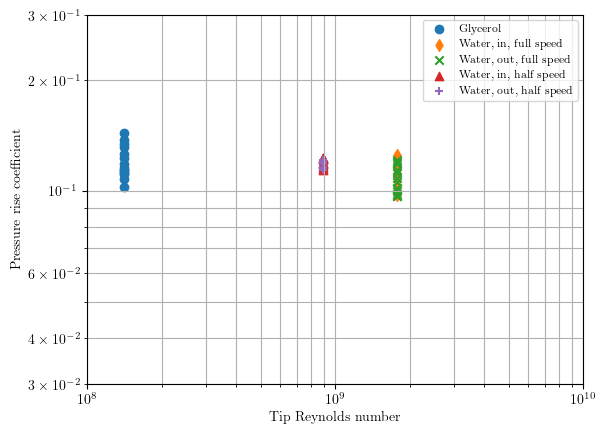

In [84]:
# plot the data vs reynolds number


def plot_water_pressure_vs_re(data, freq, marker, label = ""):


    Qdot = data["Mass Flow"] / rho_water
    N = Nf(freq)
    nonD_Q = flow_coeff(Qdot, N)
    nonD_P = pressure_coeff(data["P_rise Compresor"] * 1e3, N, rho_water)

    Re_water = rho_water * N * do**2 / dyn_visc_water
    Re = np.array([Re_water] * len(nonD_P))

    plt.scatter(
        Re,
        nonD_P,
        marker = marker,
        label = label,
    )

def plot_glycerol_pressure_vs_re(data, freq, marker, label = ""):

    Qdot = data["flow rate kg/s"] / rho_water
    N = Nf(freq)
    nonD_Q = flow_coeff(Qdot, N)
    nonD_P = pressure_coeff(data["pressure"] * 1e3, N, rho_water)
    # remove outliers

    Re_glycerol = rho_glycerol * N * do**2 / dyn_visc_glycerol
    Re_glycerol = np.array([Re_glycerol] * len(nonD_P))

    plt.scatter(
        Re_glycerol,
        nonD_P,
        marker = marker,
        label = label,
    )

plot_glycerol_pressure_vs_re(glycerol_data, 50, 'o', "Glycerol")
plot_water_pressure_vs_re(water_50_inlet_data, 50, 'd', "Water, in, full speed")
plot_water_pressure_vs_re(water_50_outlet_data, 50, 'x', "Water, out, full speed")
plot_water_pressure_vs_re(water_25_inlet_data, 25, '^', "Water, in, half speed")
plot_water_pressure_vs_re(water_25_outlet_data, 25, '+', "Water, out, half speed")

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e8, 1e10)
plt.ylim(3e-2, 3e-1)
plt.xlabel('Tip Reynolds number')
plt.ylabel('Pressure rise coefficient')
plt.legend(prop={'size': 8})
plt.grid(True, which='both')
plt.savefig('pressure_reynolds.png', dpi=300, bbox_inches='tight')

plt.show()